# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: `36`
* Students: `Muller Christophe, Bernard-Michel Martial, Coullery Ludovic, Faraut Victor`
* Dataset: `Free music archive`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

## 0 - Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install -c conda-forge pyunlocbox` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pandas as pd
import networkx as nx

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [3]:
#recovering the labels from the origin
path = '../fma_metadata/'
#read the original data
tracks = pd.read_csv(path+'tracks.csv', index_col=0, header=[0, 1])
echonest = pd.read_csv(path+'echonest.csv', index_col=0, header=[0, 1, 2])
audio_features = echonest.echonest.audio_features[['acousticness','danceability','instrumentalness']]
genres = tracks.track[['genres', 'genre_top']]
features_and_genres = audio_features.merge(genres, left_on='track_id', right_on='track_id', how='inner')
#keep pop, classic, jazz and international music
pop_genre = features_and_genres[features_and_genres.genre_top == 'Pop']
classic_genre = features_and_genres[features_and_genres.genre_top == 'Classical']
jazz_genre = features_and_genres[features_and_genres.genre_top == 'Jazz']
international_genre = features_and_genres[features_and_genres.genre_top == 'International']
select_features = pd.concat([pop_genre,classic_genre,jazz_genre,international_genre])
features = select_features.reset_index()\
            .drop(columns=['acousticness','danceability','instrumentalness','genres','track_id'])

df_key = pd.DataFrame([['Pop', 0], ['Classical', 1], ['Jazz', 2], ['International', 3]],
                      columns=['genre_top', 'genre_id'])

features_labels = pd.merge(features, df_key, how='left', on='genre_top')
features_labels_only = features_labels.drop(columns=['genre_top'])

np.save('features_labels', features_labels)
features_labels.to_csv('out_features_labels.csv')
np.save('features_labels_only', features_labels_only)
features_labels_only.to_csv('out_features_labels_only.csv')

In [3]:
features_labels = pd.read_csv('../Milestone_4/out_features_labels.csv')
features_labels_only = pd.read_csv('../Milestone_4/out_features_labels_only.csv')

In [4]:
adjacency = np.load('../Milestone_1/adjacency.npy')
n_nodes = np.size(adjacency,1) # the number of nodes in the network
n_edges = sum(sum(adjacency!=0))/2 # number of edges in the network
degrees = sum(adjacency!=0)

adjacency[adjacency>0] =1
G=nx.from_numpy_matrix(adjacency)

In [5]:
D = scipy.sparse.spdiags(degrees, [0], n_nodes, n_nodes, format='csr')
sW = scipy.sparse.csr_matrix(adjacency)
L = D-sW # combinatory
Dsqrt = scipy.sparse.spdiags(1/scipy.sqrt(degrees), [0], n_nodes, n_nodes, format='csr')

In [6]:
def matrix_to_list(matrix):
    adj_list = {}
    for i, node in enumerate(matrix):
        connected_nodes = []
        for neighbour_id, neighbour_w in enumerate(node):
            if neighbour_w >0:
                connected_nodes.append(neighbour_id)
        adj_list[i] = connected_nodes
    return adj_list

In [7]:
def compute_incidence_mat(adj_list, n_nodes, n_edges):
    
    row = np.zeros((int)(2*n_edges))
    col = np.zeros((int)(2*n_edges))
    data = np.ones((int)(2*n_edges))
    
    index = 0
    col_index = 0
    
    for node in range(0, n_nodes):
        for neighbour in adj_list[node]:
            if neighbour > node:
                row[index] = node
                col[index] = col_index
                index +=1
                row[index] = neighbour
                col[index] = col_index
                data[index] = -1
                index +=1
                col_index +=1
    
    sparse_incidence = scipy.sparse.csc_matrix((data, (row, col)),shape=(n_nodes, n_edges))
    return sparse_incidence

In [55]:
incidence = compute_incidence_mat(matrix_to_list(adjacency), n_nodes, (int)(n_edges))


In [56]:
laplacian = Dsqrt.dot(L.dot(Dsqrt))  # combinatory
gradient = incidence.toarray().transpose()
labels = features_labels_only.genre_id.tolist()
labels_mat = features_labels_only.genre_id
# labels = features_labels_only.genre_id
#n_nodes # the number of nodes in the network -> already defined and used before <-

In [11]:
gradient = np.zeros(((int)(n_edges),n_nodes))
eij = 0  # edge index
for i in range(n_nodes):
    for j in range(i, n_nodes, 1):
        wij = adjacency[i, j]
        if wij > 0:
            gradient[eij,i] = np.sqrt(wij)
            gradient[eij,j] = -np.sqrt(wij)
            eij += 1

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

In [10]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(laplacian, k=n_nodes-1)
eigenvalues = np.append([0], eigenvalues)
first_eigvect = np.ones([n_nodes, 1])/n_nodes
eig_temp = np.append(first_eigvect, eigenvectors, axis=1)
eigenvectors = eig_temp.T

In [11]:
e = eigenvalues # Ordered Laplacian eigenvalues.
U = eigenvectors # Ordered graph Fourier basis.

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

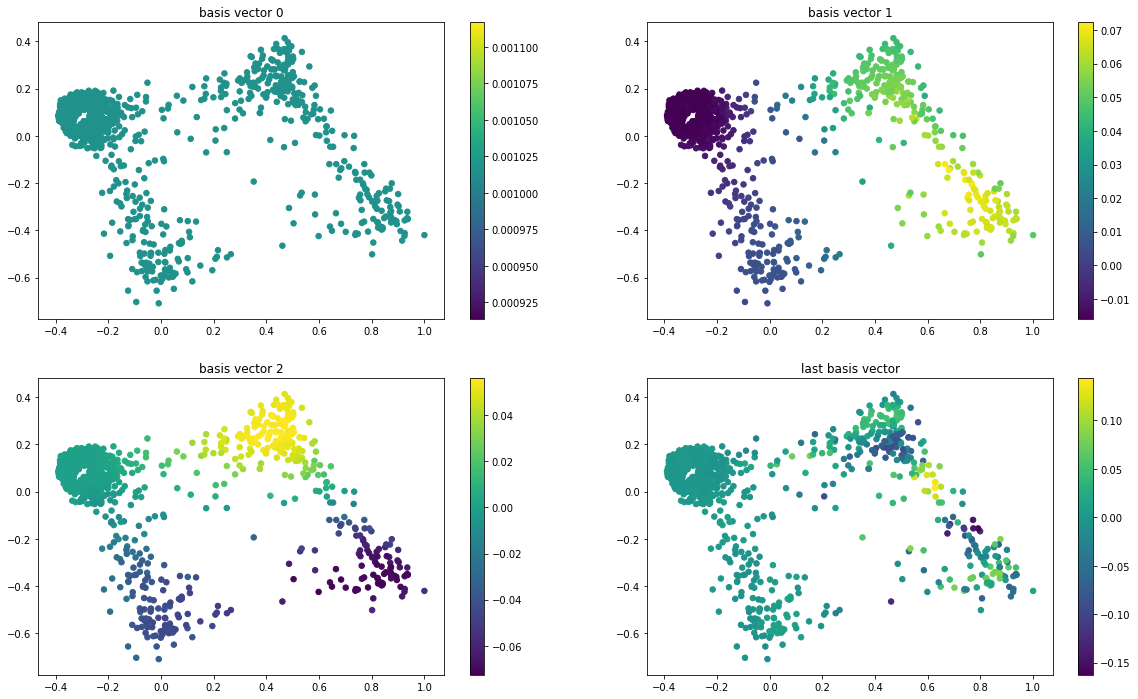

In [15]:
coords = nx.spring_layout(G)  # Force-directed layout.

fig , axs = plt.subplots(2, 2,sharex = True,sharey=True, figsize = (20,12))
ax1 = plt.subplot(221)
im1 = nx.draw_networkx_nodes(G, coords, node_size=30, node_color=eigenvectors[0, :])
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.colorbar(im1, ax = ax1)
plt.title('basis vector 0')

ax2 = plt.subplot(222)
im2 = nx.draw_networkx_nodes(G, coords, node_size=30, node_color=eigenvectors[1, :])
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.colorbar(im2, ax = ax2)
plt.title('basis vector 1')

ax3 = plt.subplot(223)
im3 = nx.draw_networkx_nodes(G, coords, node_size=30, node_color=eigenvectors[2, :])
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.colorbar(im3, ax = ax3)
plt.title('basis vector 2')

ax4 = plt.subplot(224)
im4 = nx.draw_networkx_nodes(G, coords, node_size=30, node_color=eigenvectors[n_nodes-1, :])
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.colorbar(im4, ax = ax4)
plt.title('last basis vector')

plt.show()

### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

**The difference in local variation between the firsts and the last basis vectors is really high. Indeed, the firsts basis vectors correspond to low (almost null for the first vector, as expected since there are a few imprecisions in the computations) local variations that only discriminate between the main components of the graph. On the contrary, the last basis vector corresponds to higher local variation (especially for the two upper components in the graph). This correlates well with the fact that the first eigenvalues are low and the last high.**

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [13]:
def GFT(x):
    return np.dot(x.T, U) # Your code here.

def iGFT(x_hat):
    return np.dot(x_hat, U.T)# Your code here.

### Question 4

Plot your feature/label vector as a signal on your graph

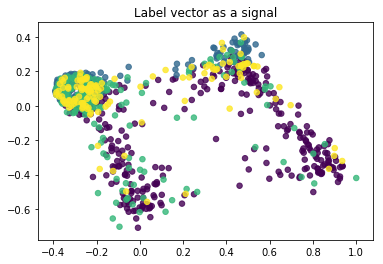

In [16]:
#labels = features_labels_only.genre_id
nx.draw_networkx_nodes(G, coords, node_size=30, node_color=labels, alpha=0.8)
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Label vector as a signal')
plt.show()

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

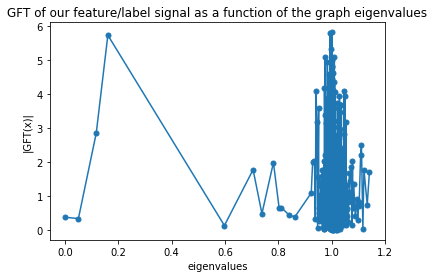

In [17]:
x = labels_mat

plt.plot(e, np.abs(GFT(labels_mat)), 'o-', markersize=5)
plt.title('GFT of our feature/label signal as a function of the graph eigenvalues')
plt.xlabel('eigenvalues')
plt.ylabel('|GFT(x)|')
plt.show()

### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

The labels don't seem to act like a well-defined filter, the repartition of colors in the plotted signal on the graph looks pretty random with a few groups. The GFT doesn't tell us much since for low eigenvalues we have quite low values compared to the max possible (this would imply a high-pass behavior) but for high eigenvalues we have a packed mix of low and high values which doesn't help us understanding the behavior at high frequencies.

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [18]:
def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    return 1/(1+t*e)

def rectangle_kernel(e, l_min, l_max):
    rKernel = np.zeros(e.size)
    rKernel[e >= l_min] = 1
    rKernel[e >= l_max] = 0
    return rKernel

def graph_filter(x, kernel, **kwargs):
    return iGFT(np.multiply(GFT(x), kernel(**kwargs)))

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

The heat kernel, having a decreasing exponential shape, cannot give a good approximation of our labels' GFT. The inverse kernel gives a similar shape and has the same problem in our case, so for both these filters we just set arbitrary parameters to see what we get. Our rectangle kernel will be centered around 1 to give a resemblance with our plot in Q4 since eigenvalues around 1 are the only ones with significantly higher values than the others.

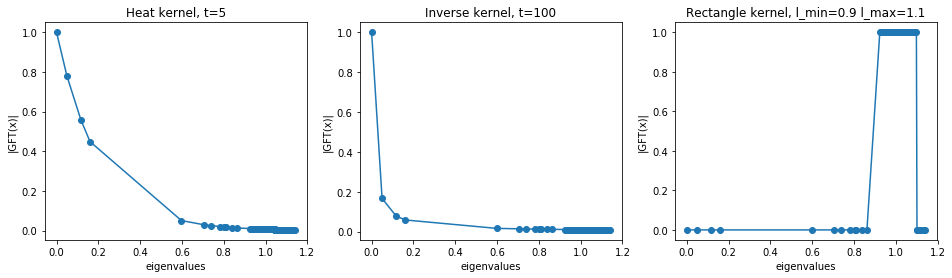

In [19]:
#plt.figure(figsize=(16,4))
plt.subplots(1,3,sharey=True, figsize=(16,4))
plt.subplot(131)
t_heat = 5
plt.plot(e, heat_kernel(e, t_heat), 'o-')
plt.title('Heat kernel, t={0}'.format(t_heat))
plt.xlabel('eigenvalues')
plt.ylabel('|GFT(x)|')

plt.subplot(132)
t_inverse = 100
plt.plot(e, inverse_kernel(e, t_inverse), 'o-')
plt.title('Inverse kernel, t={0}'.format(t_inverse))
plt.xlabel('eigenvalues')
plt.ylabel('|GFT(x)|')

plt.subplot(133)
l_min = 0.9
l_max = 1.1
plt.plot(e, rectangle_kernel(e, l_min, l_max), 'o-')
plt.title('Rectangle kernel, l_min={0} l_max={1}'.format(l_min,l_max))
plt.xlabel('eigenvalues')
plt.ylabel('|GFT(x)|')

plt.show()

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

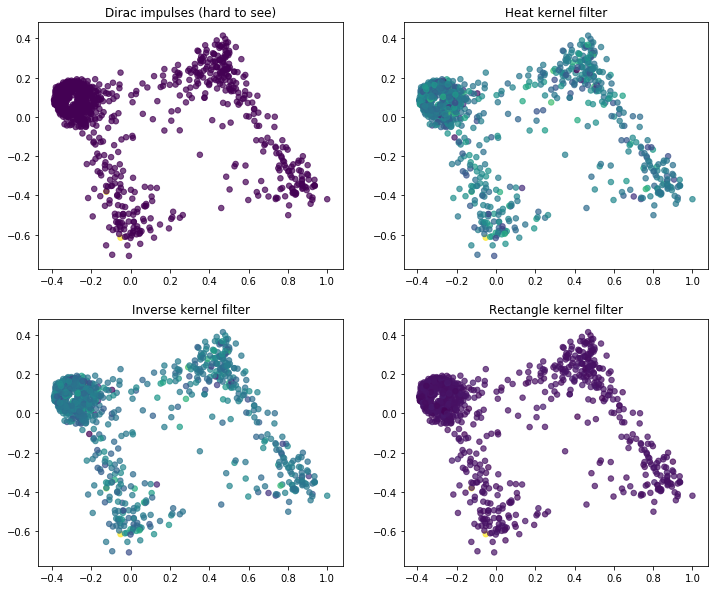

In [20]:
dirac = np.zeros((n_nodes))
dirac[[2, 10]] = 1
heated_signal = graph_filter(dirac, heat_kernel, e=e, t=t_heat)
inversed_signal = graph_filter(dirac, inverse_kernel, e=e, t=t_inverse)
rected_signal = graph_filter(dirac, rectangle_kernel, e=e, l_min = l_min, l_max = l_max)

plt.subplots(2, 2, figsize = (12,10))

plt.subplot(221)
nx.draw_networkx_nodes(G, coords, node_size=30, node_color = dirac, alpha=0.7)
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Dirac impulses (hard to see)')

plt.subplot(222)
nx.draw_networkx_nodes(G, coords, node_size=30, node_color = heated_signal, alpha=0.7)
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Heat kernel filter')

plt.subplot(223)
nx.draw_networkx_nodes(G, coords, node_size=30, node_color = inversed_signal, alpha=0.7)
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Inverse kernel filter')

plt.subplot(224)
nx.draw_networkx_nodes(G, coords, node_size=30, node_color = rected_signal, alpha=0.7)
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Rectangle kernel filter')

plt.show()

Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

The heat and inverse filters arbitrarily implemented give a pretty clean diffusion of the signal while the rectangle filter doesn't have much effect on the two Dirac impulses.
It is hard to relate those results to the real communication across our network since no model fits the GFT of the labels signal accordingly.

## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [21]:
noise_variance = np.var(labels)/1.5
noisy_measurements = labels + noise_variance * np.random.randn(n_nodes)

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

**The closed form solution of this problem is given by:**
$$
z^\star = \frac{y}{\gamma L + I},
$$
**which corresponds to a low pass filtering operation.**

### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [22]:
z_heat_denoised = graph_filter(noisy_measurements, heat_kernel, e=e, t=t_heat)
z_inv_denoised = graph_filter(noisy_measurements, inverse_kernel, e=e, t=t_inverse)
z_rect_denoised = graph_filter(noisy_measurements, rectangle_kernel, e=e, l_min = l_min, l_max=l_max)

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

In [23]:
def rel_err(z): # relative error in %
    return np.floor(100*np.linalg.norm(labels-z)/np.linalg.norm(labels))

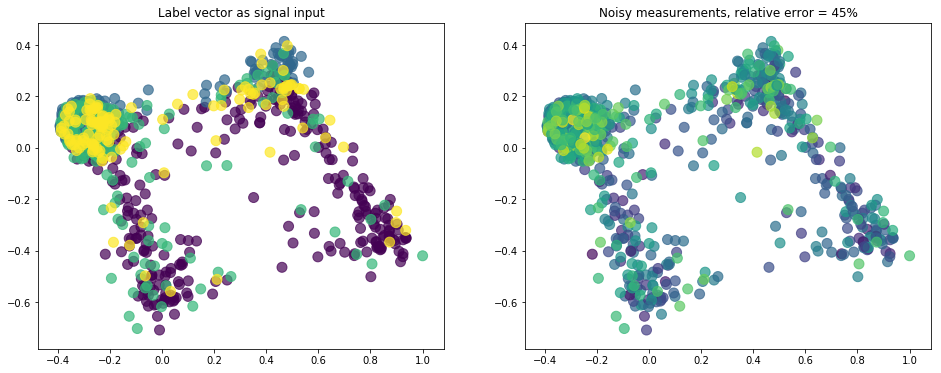

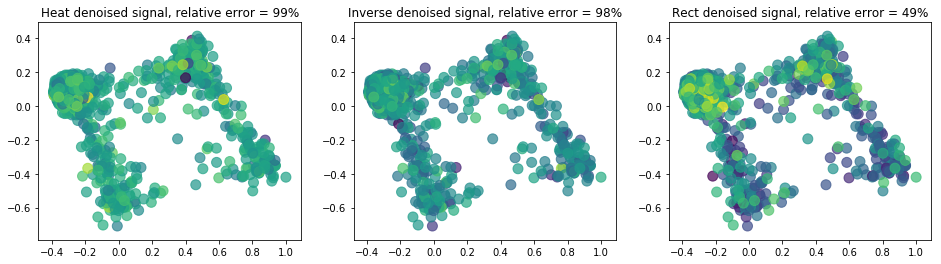

In [24]:
ns = 100
alpha = 0.7
#initial signal + noise
plt.subplots(1,2,figsize = (16,6))
plt.subplot(121)
nx.draw_networkx_nodes(G, coords, node_size=ns, node_color=labels, alpha=alpha)
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Label vector as signal input')

plt.subplot(122)
nx.draw_networkx_nodes(G, coords, node_size=ns, node_color=noisy_measurements, alpha=alpha)
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Noisy measurements, relative error = {:.0f}%'.format(rel_err(noisy_measurements)))
plt.show()

#the three denoized signals
plt.subplots(1,3,figsize = (16,4))
plt.subplot(131)
nx.draw_networkx_nodes(G, coords, node_size=ns, node_color=z_heat_denoised, alpha=alpha)
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Heat denoised signal, relative error = {:.0f}%'.format(rel_err(z_heat_denoised)))

plt.subplot(132)
nx.draw_networkx_nodes(G, coords, node_size=ns, node_color=z_inv_denoised, alpha=alpha)
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Inverse denoised signal, relative error = {:.0f}%'.format(rel_err(z_inv_denoised)))

plt.subplot(133)
nx.draw_networkx_nodes(G, coords, node_size=ns, node_color=z_rect_denoised, alpha=alpha)
#nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Rect denoised signal, relative error = {:.0f}%'.format(rel_err(z_rect_denoised)))
plt.show()

Finally, overlay on the same plot the GFT of all five signals above.

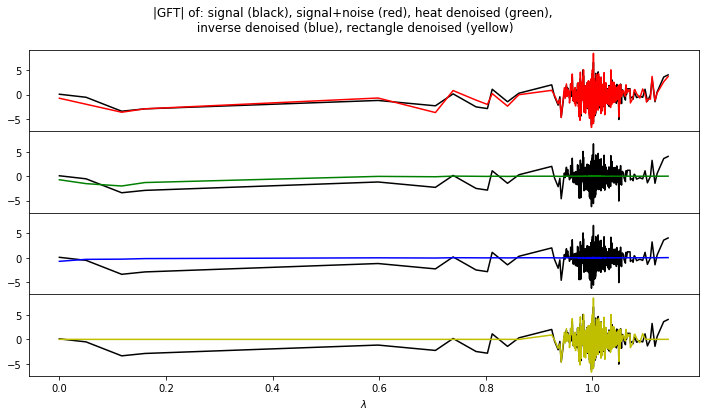

In [28]:
fig, axes = plt.subplots(4,1,figsize=(12,6), sharey=True, sharex=True)
axes[0].plot(e, GFT(labels_mat), 'k')
axes[0].plot(e, GFT(noisy_measurements), 'r')
axes[1].plot(e, GFT(labels_mat), 'k')
axes[1].plot(e, GFT(z_heat_denoised), 'g')
axes[2].plot(e, GFT(labels_mat), 'k')
axes[2].plot(e, GFT(z_inv_denoised),'b')
axes[3].plot(e, GFT(labels_mat), 'k')
axes[3].plot(e, GFT(z_rect_denoised),'y')
plt.xlabel('$\lambda$')
fig.subplots_adjust(hspace=0)
plt.suptitle('|GFT| of: signal (black), signal+noise (red), heat denoised (green),\n inverse denoised (blue), rectangle denoised (yellow)')
plt.show()

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

As expected the reconstruction is bad in every situation since no reconstruction method can approximate correctly the labels signal.
The noisy signal is still the closest from reality among all, the rectangle kernel at least gives us back the GFT around 1 and since most of the eigenvalues are found there the relative error is similar to the noisy signal.

## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

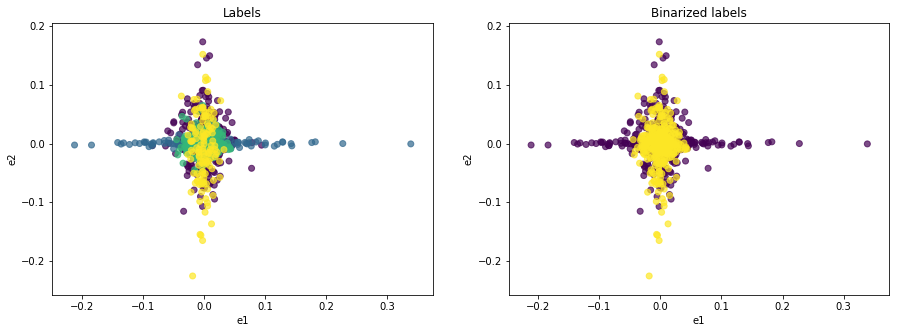

In [29]:
#labels_bin = # Your code here.

labels_bin = np.where(labels_mat < 2, -1, 1)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Labels')
plt.scatter(U[:,1], U[:,2], c=labels, alpha=0.7)
plt.xlabel('e1')
plt.ylabel('e2')


plt.subplot(122)
plt.title('Binarized labels')
plt.scatter(U[:,1], U[:,2], c=labels_bin, alpha=0.7)
plt.xlabel('e1')
plt.ylabel('e2')

plt.show()


Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [30]:
mn_ratio = 0.3
m = int(mn_ratio * n_nodes)  # Number of measurements.
w = np.random.permutation(np.concatenate((np.ones(m),np.zeros(n_nodes-m))))

Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

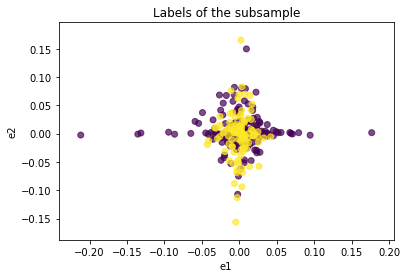

In [47]:
subsample = labels_bin * w
subsample = np.where(subsample==0, np.nan, subsample)

plt.scatter(U[:,1], U[:,2], c=subsample, alpha=0.7)
plt.xlabel('e1')
plt.ylabel('e2')
plt.title('Labels of the subsample')
plt.show()

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [48]:
def graph_pnorm_interpolation(gradient, P, w, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z,w)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [50]:
def P(a,w):
    # Your code here.
    b = labels_bin*w + a*(1-w)
    
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [33]:
gradient = scipy.sparse.csr_matrix(gradient)

#labels_bin_test = P(np.zeros(n_nodes), w)

sol_1norm_min = graph_pnorm_interpolation(gradient, P, w, x0=np.random.randn(n_nodes), p=1.) # Your code here.

sol_2norm_min = graph_pnorm_interpolation(gradient, P, w, x0=np.random.randn(n_nodes), p=2.)# Your code here.

threshold = 0

sol_1norm_bin = np.where(sol_1norm_min < 0, -1, 1)

sol_2norm_bin = np.where(sol_2norm_min < 0, -1, 1)

Solution found after 48 iterations:
    objective function f(sol) = 1.728029e+06
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 1.958696e+05
    stopping criterion: MAXIT


Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

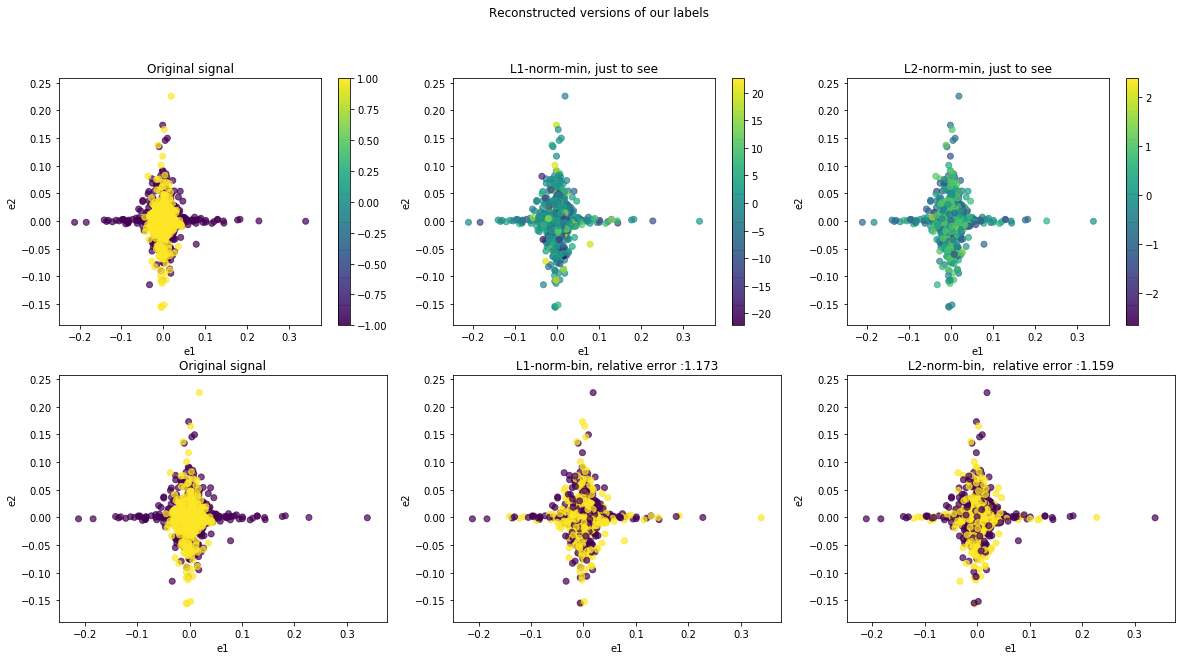

In [34]:
plt.figure(figsize=(20,10))
plt.suptitle('Reconstructed versions of our labels')

plt.subplot(231)
plt.scatter(U[:,1], U[:,2], c=labels_bin, alpha=0.7)
plt.xlabel('e1')
plt.ylabel('e2')
plt.title("Original signal")
plt.colorbar()

plt.subplot(232)
rel_error_min_1 = (np.linalg.norm(labels_bin - sol_1norm_min)/(np.linalg.norm(labels_bin)))
plt.scatter(U[:,1], U[:,2], c = sol_1norm_min, alpha=0.7)
plt.xlabel('e1')
plt.ylabel('e2')
plt.title("L1-norm-min, just to see")
plt.colorbar()

plt.subplot(233)
rel_error_min_2 = (np.linalg.norm(labels_bin - sol_2norm_min)/(np.linalg.norm(labels_bin)))
plt.scatter(U[:,1], U[:,2], c = sol_2norm_min, alpha=0.7)
plt.xlabel('e1')
plt.ylabel('e2')
plt.title("L2-norm-min, just to see")
plt.colorbar()

plt.subplot(234)
plt.scatter(U[:,1], U[:,2], c=labels_bin, alpha=0.7)
plt.xlabel('e1')
plt.ylabel('e2')
plt.title("Original signal")

plt.subplot(235)
rel_error_bin_1 = (np.linalg.norm(labels_bin - sol_1norm_bin)/(np.linalg.norm(labels_bin)))
plt.scatter(U[:,1], U[:,2], c = sol_1norm_bin, alpha=0.7)
plt.xlabel('e1')
plt.ylabel('e2')
plt.title("L1-norm-bin, relative error :{:.3f}".format(rel_error_bin_1))

plt.subplot(236)
rel_error_bin_2 = (np.linalg.norm(labels_bin - sol_2norm_bin)/(np.linalg.norm(labels_bin)))
plt.scatter(U[:,1], U[:,2], c = sol_2norm_bin, alpha=0.7)
plt.xlabel('e1')
plt.ylabel('e2')
plt.title("L2-norm-bin,  relative error :{:.3f}".format(rel_error_bin_2))
plt.show()

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

In [57]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):
    pt_matrix = np.zeros((len(mn_ratios),len(thresholds)))
    out = np.zeros((n_trials,n_nodes))
    
    # Create sample mask.
    
    for i in range(len(mn_ratios)):
        m = int(mn_ratios[i] * n_nodes)
        for j in range(n_trials):
            w = np.random.permutation(np.concatenate((np.ones(m),np.zeros(n_nodes-m))))
        
            out[j] = graph_pnorm_interpolation(gradient, P, w, x0=np.random.randn(n_nodes), p=p, rtol = 1e-4, maxit = 2000)
        for k in range(len(thresholds)):
            rel_err =0
            for j in range(n_trials):
                out_bin = np.where(out[j] < thresholds[k], -1, 1)
                rel_err += (np.linalg.norm(labels_bin - out_bin[i])/(np.linalg.norm(labels_bin)))
            pt_matrix[i,k] = rel_err/n_trials
    
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [ ]:
mn_ratios = [0.1,0.2,0.5,0.7]

thresholds = [-0.6,-0.3,0.3,0.6]

n_trials= 2

pt_matrix_1norm = phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p = 1.)

pt_matrix_2norm = phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p = 2.)

Solution found after 586 iterations:
    objective function f(sol) = 9.711094e+05
    stopping criterion: RTOL
Solution found after 142 iterations:
    objective function f(sol) = 1.501925e+06
    stopping criterion: RTOL
Solution found after 141 iterations:
    objective function f(sol) = 1.438557e+06
    stopping criterion: RTOL
Solution found after 141 iterations:
    objective function f(sol) = 1.420030e+06
    stopping criterion: RTOL
Solution found after 411 iterations:
    objective function f(sol) = 7.792250e+05
    stopping criterion: RTOL
Solution found after 140 iterations:
    objective function f(sol) = 1.083633e+06
    stopping criterion: RTOL
Solution found after 140 iterations:
    objective function f(sol) = 8.141004e+05
    stopping criterion: RTOL
Solution found after 590 iterations:
    objective function f(sol) = 4.522478e+05
    stopping criterion: RTOL
Solution found after 2000 iterations:
    objective function f(sol) = 3.903188e+04
    stopping criterion: MAXIT

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle('Transition matrix recontruction')

plt.subplot(211)
plt.title('Pt matrix 1norm')
plt.imshow(pt_matrix_1norm, aspect=2, extent=[thresholds[0],thresholds[4], mn_ratios[0],mn_ratios[4]])
plt.title('Pt matrix 1norm')
plt.ylabel('thresholds')
plt.xlabel('mn ratios')
plt.colorbar()

plt.subplot(212)
plt.imshow(pt_matrix_2norm, aspect=2, extent=[thresholds[0],thresholds[4], mn_ratios[0],mn_ratios[4]])
plt.title('Pt matrix 2norm')
plt.ylabel('thresholds')
plt.xlabel('mn ratios')
plt.colorbar()
plt.show()

# Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**Your answer here.**